In [1]:
import sys
sys.path.append("../") # go to parent dir
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

### Import data

In [4]:
item_categories = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv("../data/items.csv")
sales_train = pd.read_csv("../data/sales_train.csv")
shops = pd.read_csv("../data/shops.csv")
test_df = pd.read_csv("../data/test.csv", index_col=0)
sample_subm = pd.read_csv('../data/sample_submission.csv')

In [5]:
# Nov 2015
test_df['date_block_num'] = 34

In [6]:
# Seems useless - item_name -> item_id, item_category_id mappings are already inside items dataframe
item_categories.shape

(84, 2)

In [7]:
items.shape

(22170, 3)

In [8]:
sales_train.shape

(2935849, 6)

In [9]:
# Seems useless - Only maps to shop name
shops.shape

(60, 2)

In [10]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Let's aggregate the data monthly, as predictions are expected to be monthly as well

In [12]:
from src.staging import create_dataset

In [13]:
train_df = create_dataset(sales_train)

In [14]:
train_df["ID"] = range(len(test_df), len(test_df) + len(train_df))

In [15]:
test_df = test_df.reset_index(drop = False)

<AxesSubplot:ylabel='Frequency'>

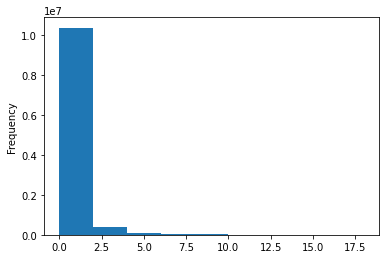

In [16]:
train_df['target'].plot(kind='hist', bins = np.arange(0,20,2))

#### All shops are included in train -> Test has only a subset of these shops

In [17]:
from src.processing import compare_sets

In [18]:
compare_sets(set(train_df['shop_id'].unique()), set(test_df['shop_id'].unique()))

set 1 size: 60
set 2 size: 42
Union size: 60
set 1 unique elements: 18
set 2 unique elements: 0


### There are new items in test never seen in train 

In [19]:
compare_sets(set(train_df['item_id'].unique()), set(test_df['item_id'].unique()))

set 1 size: 21807
set 2 size: 5100
Union size: 22170
set 1 unique elements: 17070
set 2 unique elements: 363


In [20]:
train_df['item_category_id'] = train_df['item_id'].map(items.set_index("item_id")['item_category_id'])
test_df['item_category_id'] = test_df['item_id'].map(items.set_index("item_id")['item_category_id'])

### The total quantity of products vary a lot in the training set per month, whereas all the shops in test set have the same qty of products (5100)

In [21]:
### Let's mean encode shop_id and item_id

In [22]:
from src.processing import MeanEncoding, PreviousFeatures

In [23]:
item_category_id_me = MeanEncoding(['item_category_id'], 'target')
item_category_id_me.fit(train_df)
train_df['category_enc_em'] = item_category_id_me.predict(train_df, "train")
test_df['category_enc_em'] = item_category_id_me.predict(test_df, "test")

In [24]:
item_item_id_me = MeanEncoding(['item_id'], 'target')
item_item_id_me.fit(train_df)
train_df['item_enc_em'] = item_item_id_me.predict(train_df, 'train')
test_df['item_enc_em'] = item_item_id_me.predict(test_df, "test")

In [25]:
item_shop_me = MeanEncoding(['shop_id'], 'target')
item_shop_me.fit(train_df)
train_df['shop_enc_em'] = item_shop_me.predict(train_df, 'train')
test_df['shop_enc_em'] = item_shop_me.predict(test_df, "test")

In [26]:
item_item_shop_me = MeanEncoding(['item_id','shop_id'], 'target')
item_item_shop_me.fit(train_df)
train_df['item_shop_enc_em'] = item_item_shop_me.predict(train_df, 'train')
test_df['item_shop_enc_em'] = item_item_shop_me.predict(test_df, "test")

In [27]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num']
y = train_df['target']
X = train_df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
rf = RandomForestRegressor(n_estimators=7,max_depth=7,max_features= 0.7, n_jobs=7)
rf.fit(X_train.fillna(-999), y_train)

RandomForestRegressor(max_depth=7, max_features=0.7, n_estimators=7, n_jobs=7)

In [29]:
mean_squared_error(rf.predict(X_train.fillna(-999)), y_train)

3.9160349101241447

In [30]:
mean_squared_error(rf.predict(X_test.fillna(-999)), y_test)

6.786854582609453

#### Basemodel -> Test MSE = 6.191

#### Add more features

In [31]:
from src.processing import PastAggregations

In [40]:
epsilon = 1e-6
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']
sales_train['item_category_id'] = sales_train['item_id'].map(items.set_index("item_id")['item_category_id'])

In [32]:
feat_name = "target"
for k in [1,2,3,4,5,13]:
    previous_targets = PreviousFeatures(feat_name=feat_name,unique_identifiers=['shop_id','item_id'], k = k)
    previous_targets.fit(train_df)
    new_name = feat_name + "_-" + str(k)
    train_df[new_name] = previous_targets.predict(train_df)
    test_df[new_name] = previous_targets.predict(test_df)

In [33]:
past_agg = PastAggregations(groupby_cols=['date_block_num','item_id', 'shop_id'], target_name='item_price')
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

In [37]:
past_agg = PastAggregations(groupby_cols=['date_block_num','item_id'], target_name='item_price')
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

In [38]:
train_df["mean_mean_item_discount"] = train_df["item_price_mean-by-item_id-shop_id-1"] / (train_df["item_price_mean-by-item_id-1"].fillna(0) + epsilon)
test_df["mean_mean_item_discount"] = test_df["item_price_mean-by-item_id-shop_id-1"] / (test_df["item_price_mean-by-item_id-1"].fillna(0) + epsilon)


train_df["mean_min_item_discount"] = train_df["item_price_mean-by-item_id-shop_id-1"] / (train_df["item_price_min-by-item_id-1"].fillna(0) + epsilon)
test_df["mean_min_item_discount"] = test_df["item_price_mean-by-item_id-shop_id-1"] / (test_df["item_price_min-by-item_id-1"].fillna(0) + epsilon)

In [41]:
past_agg = PastAggregations(groupby_cols=['date_block_num','shop_id'], target_name='revenue',aggregations=['sum'], k=1)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)


past_agg = PastAggregations(groupby_cols=['date_block_num','shop_id'], target_name='revenue',aggregations=['sum'],  k=13)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

In [42]:
past_agg = PastAggregations(groupby_cols=['date_block_num','item_id'], target_name='revenue',aggregations=['sum'], k=13)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)


past_agg = PastAggregations(groupby_cols=['date_block_num','item_id'], target_name='revenue',aggregations=['sum'], k=1)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

In [43]:
past_agg = PastAggregations(groupby_cols=['date_block_num','shop_id', 'item_id'], target_name='revenue',aggregations=['sum'], k=1)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

past_agg = PastAggregations(groupby_cols=['date_block_num','shop_id', 'item_id'], target_name='revenue', aggregations=['sum'], k=13)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)


In [44]:
past_agg = PastAggregations(groupby_cols=['date_block_num','item_category_id'], target_name='revenue',aggregations=['sum'], k=1)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)

past_agg = PastAggregations(groupby_cols=['date_block_num','item_category_id'], target_name='revenue',aggregations=['sum'], k=13)
past_agg.fit(sales_train)
train_df = pd.concat([train_df, past_agg.predict(train_df)], axis = 1)
test_df = pd.concat([test_df, past_agg.predict(test_df)], axis = 1)


In [45]:
train_df['rev_shop_ratio'] = train_df["revenue_sum-by-shop_id-1"]/(train_df["revenue_sum-by-shop_id-13"].fillna(0) + epsilon)
test_df['rev_shop_ratio'] = test_df["revenue_sum-by-shop_id-1"]/(test_df["revenue_sum-by-shop_id-13"].fillna(0) + epsilon)

In [47]:
train_df["rev_item_ratio"] = train_df['revenue_sum-by-item_id-1']/(train_df['revenue_sum-by-item_id-13'].fillna(0) + epsilon)
test_df["rev_item_ratio"] = test_df['revenue_sum-by-item_id-1']/(test_df['revenue_sum-by-item_id-13'].fillna(0) + epsilon)

In [48]:
train_df['rev_shop_item_ratio'] = train_df["revenue_sum-by-shop_id-item_id-1"]/(train_df["revenue_sum-by-shop_id-item_id-1"].fillna(0)+epsilon)
test_df['rev_shop_item_ratio'] = test_df["revenue_sum-by-shop_id-item_id-1"]/(test_df["revenue_sum-by-shop_id-item_id-1"].fillna(0)+epsilon)

In [55]:
train_df['rev_category_ratio'] = train_df["revenue_sum-by-shop_id-item_id-1"]/(train_df["revenue_sum-by-shop_id-item_id-1"].fillna(0)+epsilon)
test_df['rev_category_ratio'] = test_df["revenue_sum-by-shop_id-item_id-1"]/(test_df["revenue_sum-by-shop_id-item_id-1"].fillna(0)+epsilon)

In [56]:
train_df['rev_category_ratio'] = train_df['revenue_sum-by-item_category_id-1']/(train_df['revenue_sum-by-item_category_id-13'].fillna(0) + epsilon)
test_df['rev_category_ratio'] = test_df['revenue_sum-by-item_category_id-1']/(test_df['revenue_sum-by-item_category_id-13'].fillna(0) + epsilon)

In [60]:
features = [
 'category_enc_em',
 'item_enc_em',
 'shop_enc_em',
 'item_shop_enc_em',
 'target_-1',
 'target_-13',
 'mean_mean_item_discount',
 'mean_min_item_discount',
 'rev_shop_ratio',
 'rev_item_ratio',
 'rev_shop_item_ratio',
 'rev_category_ratio']

y = train_df['target']
X = train_df[features]

X = X.fillna(-999)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
rf = RandomForestRegressor(n_estimators=7,max_depth=7,max_features= 0.7, n_jobs=7)
rf.fit(X_train.fillna(-999), y_train)

RandomForestRegressor(max_depth=7, max_features=0.7, n_estimators=7, n_jobs=7)

In [67]:
mean_squared_error(rf.predict(X_train.fillna(-999)), y_train)

4.003573798883332

In [77]:
mean_squared_error(rf.predict(X_test.fillna(-999)), y_test, squared=False)

2.1690391033402205

### Predict test data

In [68]:
predictions = rf.predict(test_df[features].fillna(-999))

In [69]:
predictions = pd.DataFrame(data = {"ID":test_df['ID'], "item_cnt_month" :predictions})

In [70]:
predictions

,ID,item_cnt_month
0,0,0.566633
1,1,0.120101
2,2,0.765727
3,3,0.359800
4,4,0.120101
...,...,...
214195,214195,0.665831
214196,214196,0.101509
214197,214197,0.101509
214198,214198,0.101509


In [73]:
predictions.to_csv("prediction_2021_11_07.csv", index=None)

#### Investigation

<AxesSubplot:xlabel='date_block_num'>

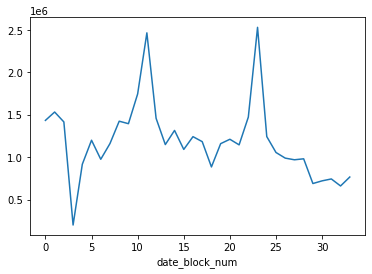

In [83]:
total_rev[total_rev['shop_id'] == 4].set_index('date_block_num')['revenue'].plot()

In [192]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [182]:
xgb_reg.score(X_train, y_train)

0.3492571986132471

In [183]:
xgb_reg.score(X_test, y_test)

0.3338165417624763